# Data Load and Exploration


This notebook encompasses the data extraction processes and the exploratory data analysis. 



In [1]:
import requests
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import xlrd
import re
import warnings
warnings.filterwarnings('ignore')

from bs4 import BeautifulSoup
from urllib.parse import urljoin
from datetime import datetime   

#print(os.getcwd())
ROOT_DIR = os.path.dirname(os.path.dirname(os.path.abspath("ds_proj1")))
os.chdir(ROOT_DIR)
print(os.getcwd())

#from scripts import ptools

d:\00_DEVELOPER\globant\ds_proj1


## Web scraping for data

Due to a lack of essential elements and knowledge in the proposed data API by the database author, an alternative approach was developed involving a web scraping pipeline. This process began with systematically accessing specific URLs to retrieve data. The focus was on URLs that contained relevant datasets, which were then extracted for analysis.

In [39]:
# detect links
web_url = 'https://www.cityobservatory.birmingham.gov.uk/@birmingham-city-council/purchase-card-transactions/'
response = requests.get(web_url)

# Create a BeautifulSoup object to parse the HTML
soup = BeautifulSoup(response.text, 'html.parser')
# Find all 'a' tags (links) in the HTML
links = soup.find_all('a')

# Extract links with the specified extension and pattern
all_links = [urljoin(web_url, link.get('href')) for link in links if link.get('href') and link.get('href').endswith('.xls')]
xls_links = list(filter(lambda link: '.datopian.' in link, all_links))

# Print the total number of links found
print(f"There are {len(xls_links)} links ending with '.xls' extension in the list.")

# Print the last 3 links from the list
if xls_links:
    print("Sample links ending with '.xls' extension looks like:")
    for idx, link in enumerate(xls_links[-3:], start=len(xls_links) - 2):
        print(f"{idx}. {link}")

There are 114 links ending with '.xls' extension in the list.
Sample links ending with '.xls' extension look like:
112. https://birmingham-city-observatory.datopian.com/dataset/cf552d08-cee9-43bf-8c0f-3196a9311799/resource/91490172-de65-4cfe-95eb-37fc3d7e82b1/download/purchase-card-transactions-september-23-.xls
113. https://birmingham-city-observatory.datopian.com/dataset/cf552d08-cee9-43bf-8c0f-3196a9311799/resource/c1ad45e4-4412-42a1-b196-9e6d0ab433e3/download/purchase-card-transactions-october-23.xls
114. https://birmingham-city-observatory.datopian.com/dataset/cf552d08-cee9-43bf-8c0f-3196a9311799/resource/018e4dfd-e8c1-40c8-85f2-7b7a1b63345e/download/purchase-card-transactions-november-23-.xls


- The final step involved the selection of specific time periods for in-depth analysis. This selection was based on the most recent and relevant data

In [5]:
# List of URLs
urls = xls_links.copy()

# Función completa que integra la extracción de fechas de una lista de URLs y encuentra los últimos 6 meses disponibles
def extract_dates_and_find_last_6_months(urls):
    # Diccionario para mapear nombres de meses posiblemente incompletos a nombres completos
    months = {
        'jan': 'January', 'feb': 'February', 'mar': 'March', 'apr': 'April', 
        'may': 'May', 'jun': 'June', 'jul': 'July', 'aug': 'August', 
        'sep': 'September', 'oct': 'October', 'nov': 'November', 'dec': 'December'
    }

    # Función para extraer y formatear las fechas
    def format_year_month(url):
        file_name = url.split('/')[-1].lower()
        match = re.search(r'(\w+)(\d{2,4})', file_name.replace('-', ''))
        if match:
            month_part, year = match.group(1), match.group(2)
            year = f"20{year}" if len(year) == 2 else year

            for short_month, full_month in months.items():
                if short_month in month_part:
                    return f"{year} {full_month}"

            # Intento alternativo para extraer el mes
            month_match = re.search(r'(jan|feb|mar|apr|may|jun|jul|aug|sep|oct|nov|dec)', month_part)
            return f"{year} {months[month_match.group(0)]}" if month_match else None
        return None

    # Extraer y formatear las fechas de las URLs
    formatted_dates = [format_year_month(url) for url in urls]

    # Obtener la fecha actual
    current_date = datetime.now()
    current_year = current_date.year
    current_month = current_date.strftime("%B")

    # Función para obtener los índices de los últimos 6 meses disponibles
    def get_last_6_months_indices(dates, current_year, current_month):
        valid_dates = [(i, date) for i, date in enumerate(dates) if date is not None]
        date_objects = [(index, datetime.strptime(date, '%Y %B')) for index, date in valid_dates]
        date_objects.sort(key=lambda x: x[1], reverse=True)

        last_6_months_indices = []
        for index, date in date_objects:
            if date.year == current_year and date.strftime("%B") == current_month:
                last_6_months_indices.append(index)
                if len(last_6_months_indices) == 6:
                    break
            elif date < datetime(current_year, current_date.month, 1):
                last_6_months_indices.append(index)
                if len(last_6_months_indices) == 6:
                    break

        return last_6_months_indices

    # Encontrar y devolver los índices de los últimos 6 meses disponibles
    return get_last_6_months_indices(formatted_dates, current_year, current_month)


# Identificar los índices de los últimos 6 meses disponibles
last_6_months_indices = extract_dates_and_find_last_6_months(urls)
print(last_6_months_indices)


[112, 111, 110, 54, 53, 52]



-  Identifying and extracting the last six months of available data from the list of URLs.

In [18]:
# Time-period data 
import os 
to_download = [urls[i] for i in last_6_months_indices]
print(to_download)


def download_documents(links, destination_directory='downloads'):
    """
    Downloads documents from a list of direct download links.

    Parameters:
        links (list): List of direct download links.
        destination_directory (str): Directory where downloaded documents will be saved.

    Returns:
        list: List of paths to the downloaded documents.
    """
    # Create the destination directory if it doesn't exist
    if not os.path.exists(destination_directory):
        os.makedirs(destination_directory)

    document_paths = []

    for idx, link in enumerate(links, start=1):
        try:
            # Get the content of the document
            response = requests.get(link)
            response.raise_for_status()

            # Get the filename from the link
            file_name = os.path.join(destination_directory, f"document_{idx}.xls")

            # Save the content to a local file
            with open(file_name, 'wb') as file:
                file.write(response.content)

            document_paths.append(file_name)
            print(f"Document {idx} downloaded successfully: {file_name}")

        except requests.exceptions.RequestException as e:
            print(f"Error downloading document {idx} from {link}: {e}")

    return document_paths


downloaded_documents = download_documents(to_download, destination_directory= 'data/raw')


['https://birmingham-city-observatory.datopian.com/dataset/cf552d08-cee9-43bf-8c0f-3196a9311799/resource/c1ad45e4-4412-42a1-b196-9e6d0ab433e3/download/purchase-card-transactions-october-23.xls', 'https://birmingham-city-observatory.datopian.com/dataset/cf552d08-cee9-43bf-8c0f-3196a9311799/resource/91490172-de65-4cfe-95eb-37fc3d7e82b1/download/purchase-card-transactions-september-23-.xls', 'https://birmingham-city-observatory.datopian.com/dataset/cf552d08-cee9-43bf-8c0f-3196a9311799/resource/37f8cc65-2306-4ec6-a460-bc647243013d/download/purchase-card-transactions-august-23-.xls', 'https://birmingham-city-observatory.datopian.com/dataset/cf552d08-cee9-43bf-8c0f-3196a9311799/resource/12f02d82-654b-4413-9a44-39c950cf62e0/download/purchase-card-transactions-july-23.xls', 'https://birmingham-city-observatory.datopian.com/dataset/cf552d08-cee9-43bf-8c0f-3196a9311799/resource/0a95cf0d-289a-4570-9e52-f7e3ce6da541/download/purchase-cards-transactions-june-23.xls', 'https://birmingham-city-observ

- URLs were downloaded, the next step in the web scraping pipeline involved concatenating these datasets into a unified format. 

In [19]:

def load_and_concatenate_xls(directory="data/raw/"):
    """
    Load and concatenate Excel (xls) files into a single DataFrame.

    Parameters:
        directory (str): Directory containing the xls files.

    Returns:
        pd.DataFrame: DataFrame containing combined information from all xls files.
    """
    frames = []

    # Iterate through all files in the directory
    for file in os.listdir(directory):
        if file.endswith(".xls"):
            # Build the full file path
            file_path = os.path.join(directory, file)

            # Read the Excel file into a DataFrame
            df = pd.read_excel(file_path)

            # Add the DataFrame to the list of DataFrames
            frames.append(df)

    # Concatenate all DataFrames into one
    result = pd.concat(frames, ignore_index=True)

    return result

# Call the function to load and concatenate the xls files
rawdata = load_and_concatenate_xls()

## Exploratory Data Analysis 
I'll start by conducting an Exploratory Data Analysis (EDA). This process typically involves the following steps:

In [22]:
# Creating raw data copy
df = rawdata.copy()
print(df.shape)


(22810, 23)



### Loading and Inspecting the Data:
I'll begin by loading the data into a DataFrame to understand its structure, such as the number of rows, columns, and the type of data it contains.


In [23]:
# Basic information about the dataset
data_info = df.info()
print(data_info)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22810 entries, 0 to 22809
Data columns (total 23 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   TRANS DATE              22810 non-null  datetime64[ns]
 1   TRANS TAX DESC          22573 non-null  object        
 2   ORIGINAL GROSS AMT      22810 non-null  float64       
 3   ORIGINAL CUR            22810 non-null  object        
 4   BILLING CUR CODE        14534 non-null  object        
 5   BILLING GROSS AMT       22810 non-null  float64       
 6   TRANS TAX AMT           22810 non-null  float64       
 7   TRANS ORIGINAL NET AMT  18762 non-null  float64       
 8   MERCHANT NAME           22810 non-null  object        
 9   CARD NUMBER             22810 non-null  object        
 10  TRANS CAC CODE 1        22807 non-null  object        
 11  TRANS CAC CODE 2        22801 non-null  object        
 12  TRANS CAC DESC 2        7583 non-null   object

The dataset contains several columns related to transactions. Here's a brief overview of the columns:

- **TRANS DATE**: The date of the transaction.
- **TRANS TAX DESC**: Description related to tax of the transaction.
- **ORIGINAL GROSS AMT**: The original gross amount of the transaction.
- **ORIGINAL CUR**: The original currency of the transaction.
- **BILLING GROSS AMT**: The billed gross amount.
- **BILLING CUR CODE**: The billing currency code.
- **TRANS TAX AMT**: The transaction tax amount.
- **TRANS ORIGINAL NET AMT**: The original net amount of the transaction.
- **CARD NUMBER**: The card number used for the transaction.
- **TRANS CAC CODE 1, 2, 3**: Various transaction codes.
- **TRANS CAC DESC 1, 2**: Descriptions for transaction codes.
- **Directorate**: Directorate involved in the transaction.
- **MERCHANT NAME**: Name of the merchant.


### Summary Statistics and Data Cleaning: 
I'll check for summary statistics and look for any missing or inconsistent data that needs cleaning.


In [24]:
# Checking for missing values
missing_values = df.isnull().sum()
print(missing_values)

TRANS DATE                    0
TRANS TAX DESC              237
ORIGINAL GROSS AMT            0
ORIGINAL CUR                  0
BILLING CUR CODE           8276
BILLING GROSS AMT             0
TRANS TAX AMT                 0
TRANS ORIGINAL NET AMT     4048
MERCHANT NAME                 0
CARD NUMBER                   0
TRANS CAC CODE 1              3
TRANS CAC CODE 2              9
TRANS CAC DESC 2          15227
TRANS CAC CODE 3           3212
TRANS CAC CODE 4              6
TRANS CAC CODE 5              8
TRANS CAC CODE 6             11
TRANS CAC CODE 7              6
TRANS CAC CODE 8              6
DIRECTORATE               15064
Directorate                7746
BILLING CUR CODE.1        20682
TRANS TAX RATE            18762
dtype: int64


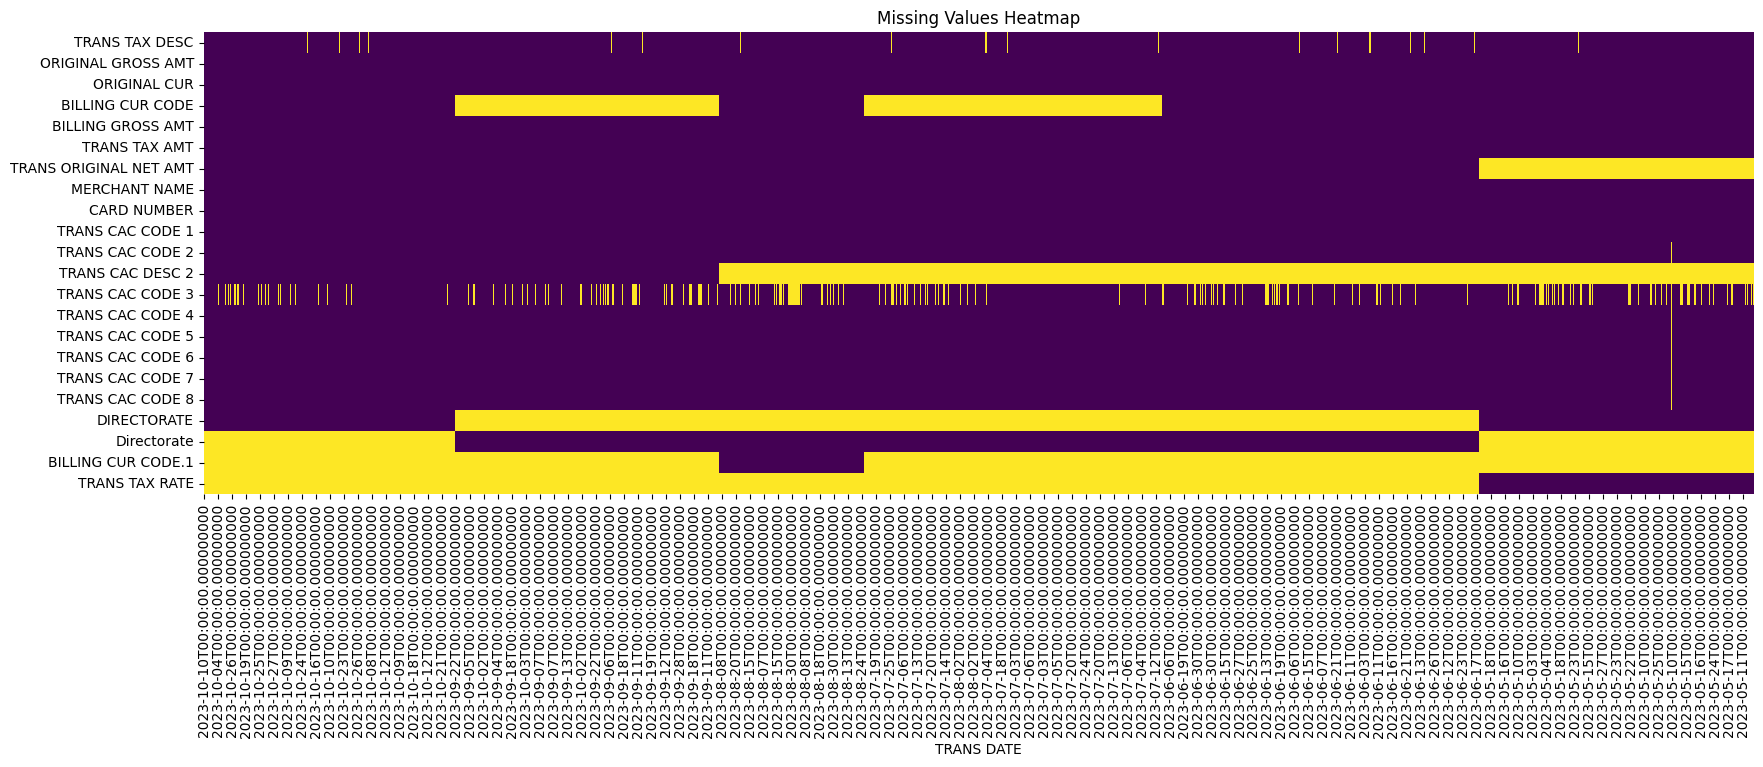

In [25]:
# Visualize missing values with datetime on the y-axis
df['TRANS DATE'] = pd.to_datetime(df['TRANS DATE'])

plt.figure(figsize=(20, 6))
sns.heatmap(rawdata.set_index('TRANS DATE').isnull().transpose(), cmap='viridis',  cbar=False)
# format the x-axis tick labels as dates
plt.xticks(rotation=90)
#plt.gca().set_xticklabels(data['TRANS DATE'].data.strftime('%Y-%m'))
plt.title('Missing Values Heatmap')
plt.show()

In [26]:

# Descriptive statistics for numerical features
numerical_stats = df.describe()
print(numerical_stats)


       ORIGINAL GROSS AMT  BILLING GROSS AMT  TRANS TAX AMT  \
count        22810.000000       22810.000000   22810.000000   
mean           148.786839         129.124824       9.550393   
std           2044.315907         436.569646      37.719914   
min          -1453.000000       -1453.000000    -152.500000   
25%             16.990000          16.990000       0.000000   
50%             50.690000          50.500000       0.830000   
75%            105.142500         105.057500       9.880000   
max         279200.000000       19102.320000    1737.000000   

       TRANS ORIGINAL NET AMT  TRANS TAX RATE  
count            18762.000000     4048.000000  
mean               119.403665       13.936512  
std                419.448224        9.166482  
min              -1000.000000        0.000000  
25%                 15.282500        0.000000  
50%                 45.745000       20.000000  
75%                 94.050000       20.000000  
max              19102.320000       20.000000  


In [27]:

# Checking clean shape 
rows, cols = df.shape 
director = df.Directorate.unique().shape[0]

# Checking unique values for categorical features
categorical_columns = df.select_dtypes(include=['object', 'category']).columns
unique_values = df[categorical_columns].nunique()


# Summarizing the analysis
print(unique_values.to_frame(name='Unique Values'))


                    Unique Values
TRANS TAX DESC                  8
ORIGINAL CUR                    6
BILLING CUR CODE                1
MERCHANT NAME                4748
CARD NUMBER                   625
TRANS CAC CODE 1                4
TRANS CAC CODE 2              289
TRANS CAC DESC 2              207
TRANS CAC CODE 3              120
TRANS CAC CODE 4               32
TRANS CAC CODE 5               15
TRANS CAC CODE 6              261
TRANS CAC CODE 7                2
TRANS CAC CODE 8                2
DIRECTORATE                    17
Directorate                    20
BILLING CUR CODE.1              1



### Numerical Data Analysis:
    - Correlation Analysis: I'll examine the correlation between numerical features.
    - Visualization: Plotting correlation matrices or scatter plots to visualize these relationships.

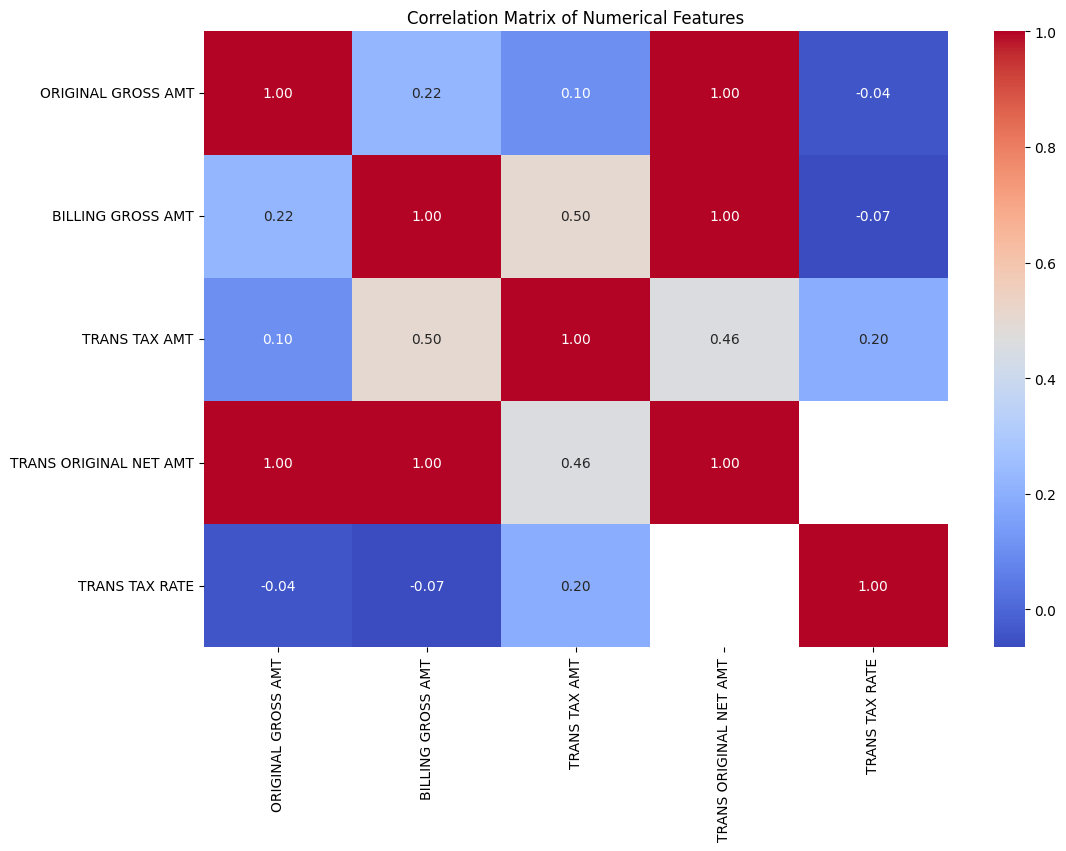

In [29]:
# Correlation matrix for numerical features
correlation_matrix = df.corr()

# Plotting the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Numerical Features')
plt.show()

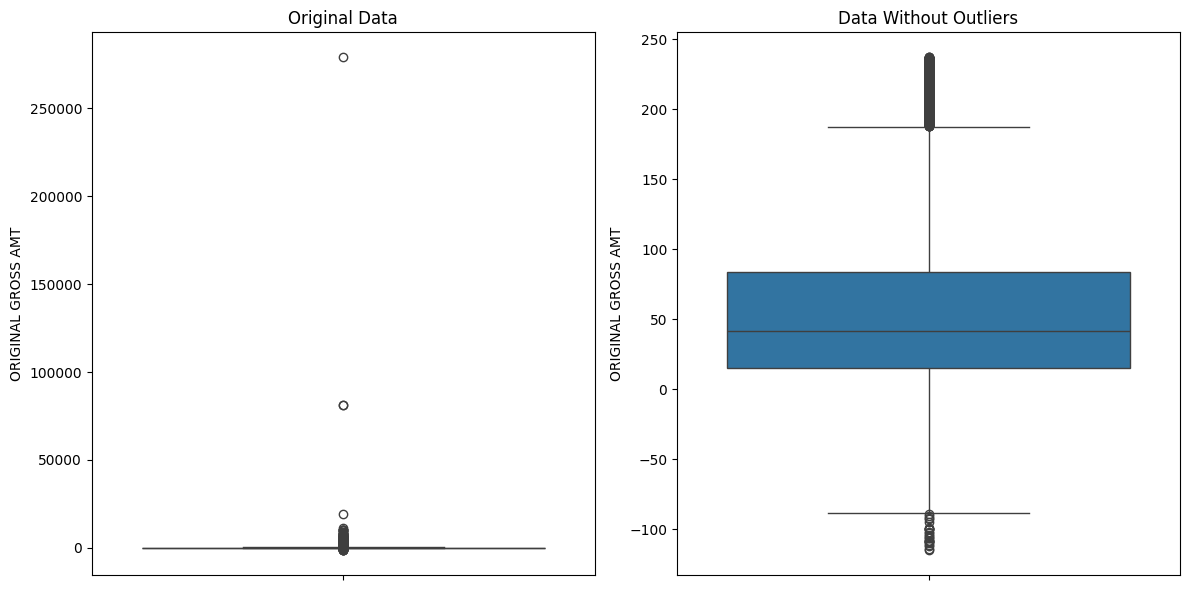

In [30]:
# Outlier detection for 'ORIGINAL GROSS AMT'
Q1 = df['ORIGINAL GROSS AMT'].quantile(0.25)
Q3 = df['ORIGINAL GROSS AMT'].quantile(0.75)
IQR = Q3 - Q1

# Defining bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filtering out the outliers
data_no_outliers = df[
    (df['ORIGINAL GROSS AMT'] >= lower_bound) & 
    (df['ORIGINAL GROSS AMT'] <= upper_bound)
]

# Plotting the original and outlier-removed distributions for comparison
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.boxplot(data=df['ORIGINAL GROSS AMT'])
plt.title('Original Data')

plt.subplot(1, 2, 2)
sns.boxplot(data=data_no_outliers['ORIGINAL GROSS AMT'])
plt.title('Data Without Outliers')

plt.tight_layout()
plt.show()

   
### Categorical Data Analysis:
    - Column Plotting: I'll plot the categorical data to understand their distribution and relationships.


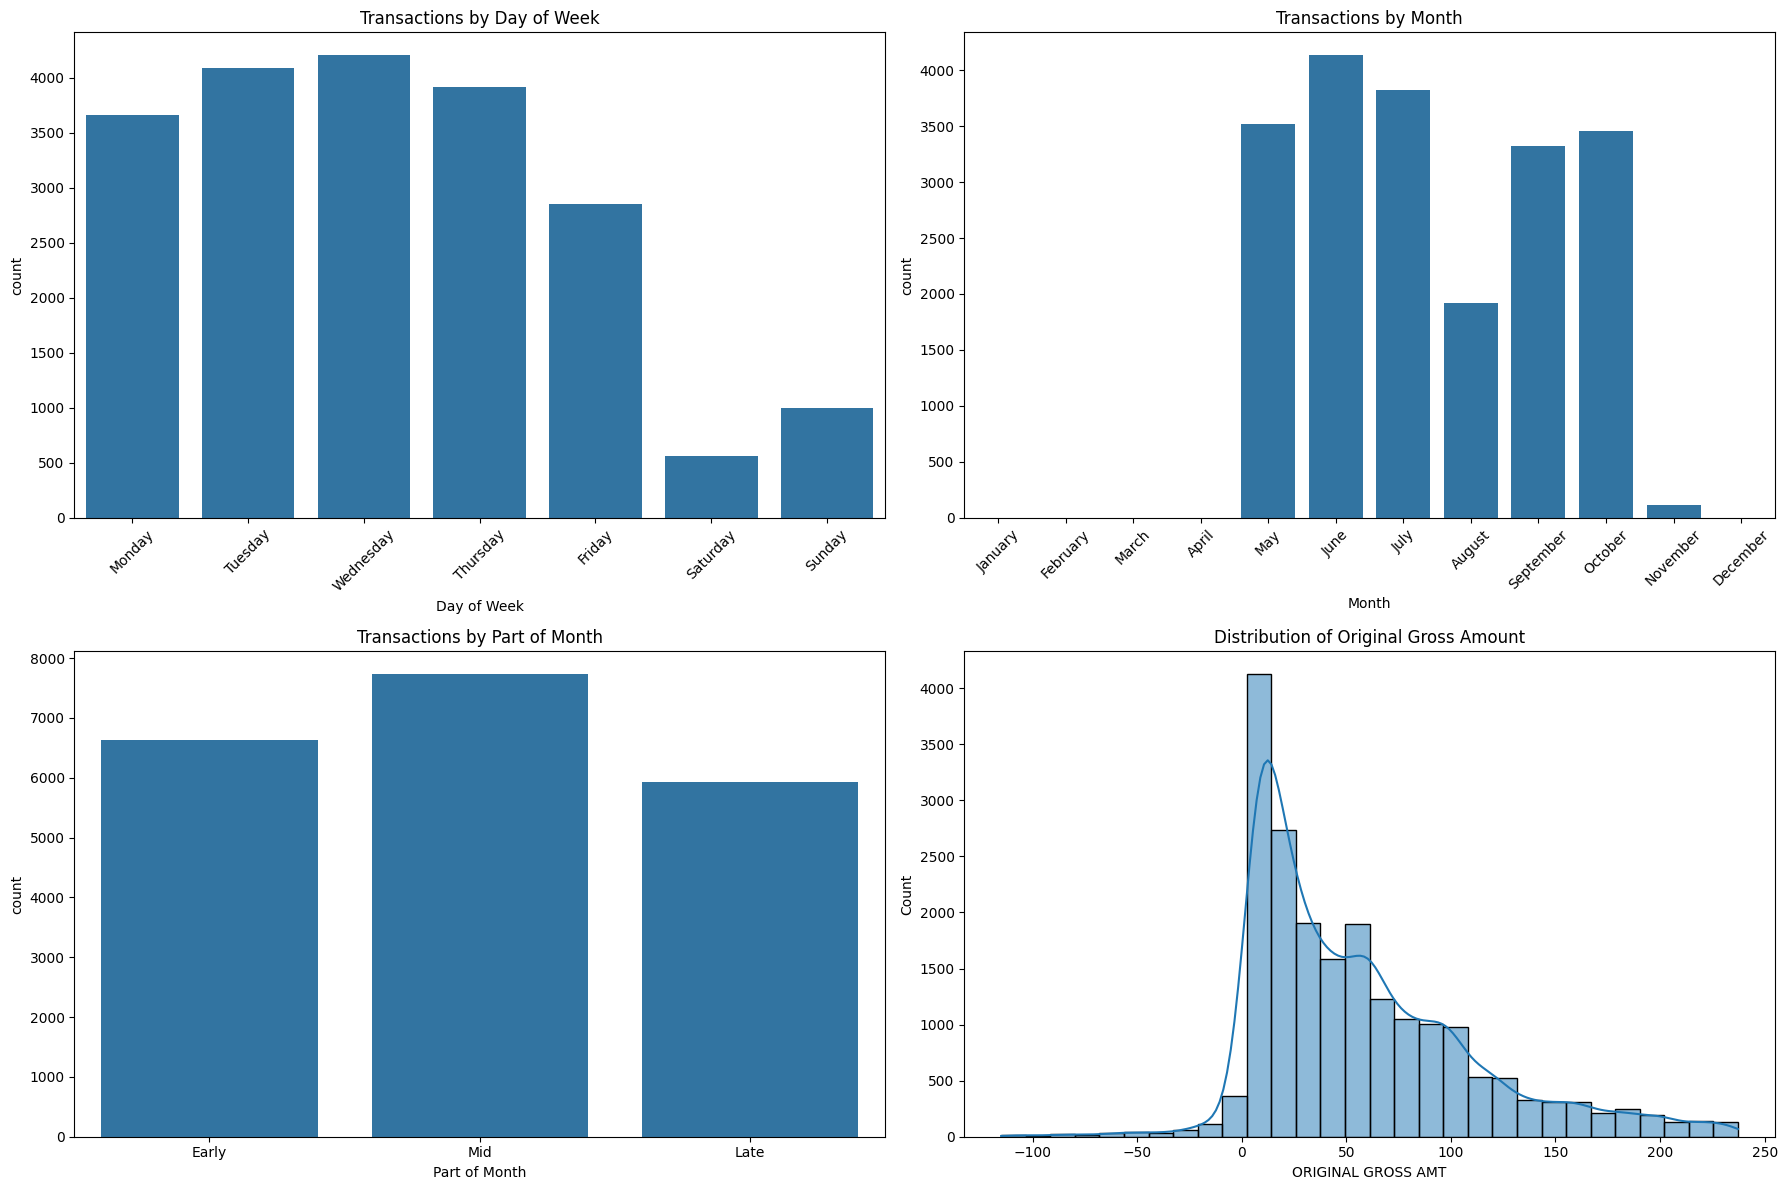

In [31]:
# EDA: Creating visualizations for business-related insights

# Day of the Week
data_no_outliers['Day of Week'] = data_no_outliers['TRANS DATE'].dt.day_name()

# Month
data_no_outliers['Month'] = data_no_outliers['TRANS DATE'].dt.month_name()

# Part of Month (Early: 1-10, Mid: 11-20, Late: 21-end)
def part_of_month(day):
    if day <= 10:
        return 'Early'
    elif day <= 20:
        return 'Mid'
    else:
        return 'Late'

data_no_outliers['Part of Month'] = data_no_outliers['TRANS DATE'].dt.day.apply(part_of_month)

# Displaying the new features
data_no_outliers[['TRANS DATE', 'Day of Week', 'Month', 'Part of Month']].head()
plt.figure(figsize=(18, 12))

# Distribution of transactions over days of the week
plt.subplot(2, 2, 1)
sns.countplot(data=data_no_outliers, x='Day of Week', order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.title('Transactions by Day of Week')
plt.xticks(rotation=45)

# Distribution of transactions over months
plt.subplot(2, 2, 2)
sns.countplot(data=data_no_outliers, x='Month', order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'])
plt.title('Transactions by Month')
plt.xticks(rotation=45)

# Distribution of transactions in parts of the month
plt.subplot(2, 2, 3)
sns.countplot(data=data_no_outliers, x='Part of Month')
plt.title('Transactions by Part of Month')

# Distribution of 'ORIGINAL GROSS AMT'
plt.subplot(2, 2, 4)
sns.histplot(data_no_outliers['ORIGINAL GROSS AMT'], bins=30, kde=True)
plt.title('Distribution of Original Gross Amount')

plt.tight_layout()
plt.show()

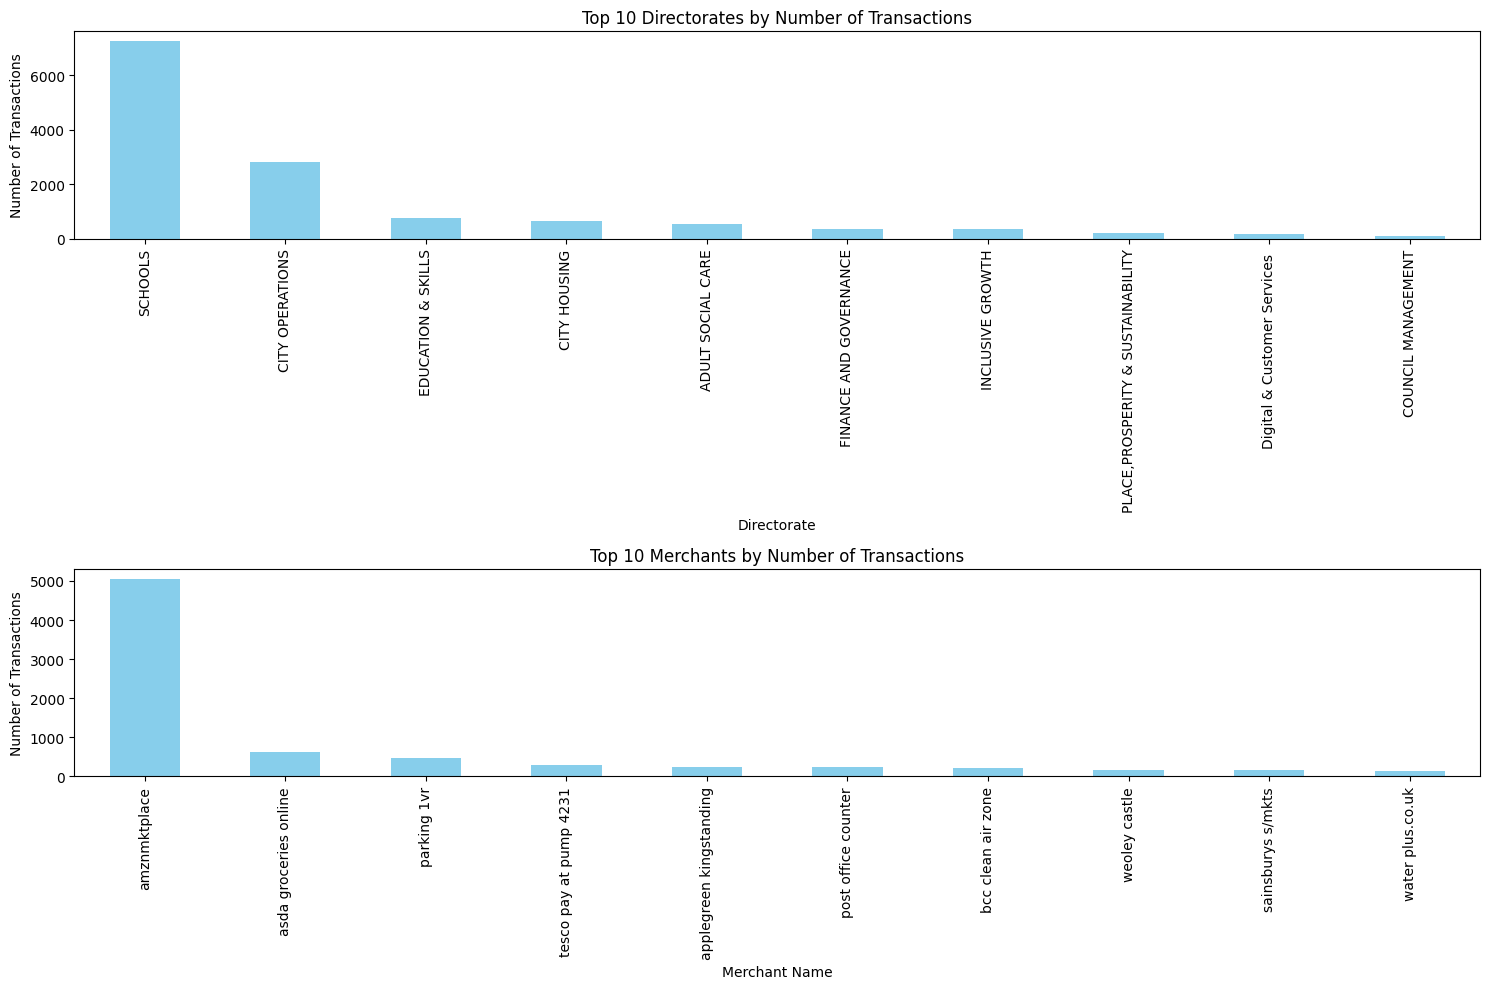

In [32]:
# Plotting the distribution of transactions for 'Directorate' and 'MERCHANT NAME'
plt.figure(figsize=(15, 10))

# Transactions Count by Directorate
plt.subplot(2, 1, 1)
data_no_outliers['Directorate'].value_counts().head(10).plot(kind='bar', color='skyblue')
plt.xticks(rotation=90)
plt.title('Top 10 Directorates by Number of Transactions')
plt.xlabel('Directorate')
plt.ylabel('Number of Transactions')

# Transactions Count by MERCHANT NAME
plt.subplot(2, 1, 2)
data_no_outliers['MERCHANT NAME'].value_counts().head(10).plot(kind='bar', color='skyblue')
plt.xticks(rotation=90)
plt.title('Top 10 Merchants by Number of Transactions')
plt.xlabel('Merchant Name')
plt.ylabel('Number of Transactions')

plt.tight_layout()
plt.show()

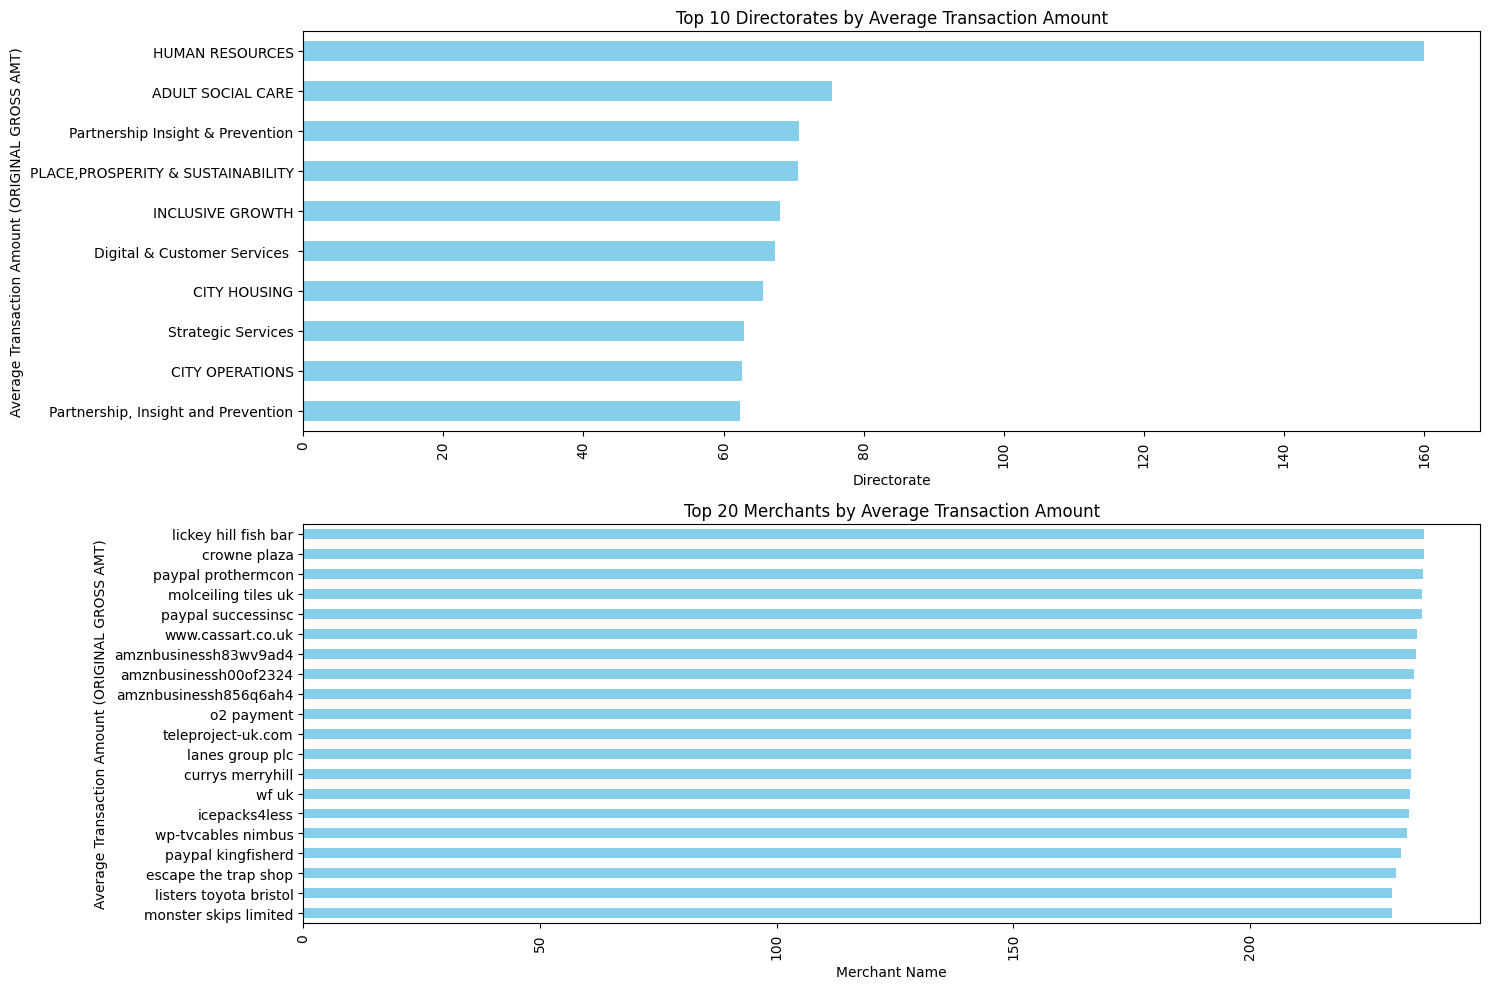

In [33]:
# Calculating the average ORIGINAL GROSS AMT for each Directorate and Merchant
avg_gross_amt_by_directorate = data_no_outliers.groupby('DIRECTORATE')['ORIGINAL GROSS AMT'].mean().sort_values(ascending=False).head(10)
avg_gross_amt_by_merchant = data_no_outliers.groupby('MERCHANT NAME')['ORIGINAL GROSS AMT'].mean().sort_values(ascending=False).head(20)

# Plotting the average ORIGINAL GROSS AMT for Directorates and Merchants
plt.figure(figsize=(15, 10))

# Average Gross Amount by Directorate
plt.subplot(2, 1, 1)
aa = avg_gross_amt_by_directorate.plot(kind='barh', color='skyblue')
plt.xticks(rotation=90)
plt.title('Top 10 Directorates by Average Transaction Amount')
plt.xlabel('Directorate')
plt.ylabel('Average Transaction Amount (ORIGINAL GROSS AMT)')
aa.invert_yaxis()

# Average Gross Amount by Merchant
plt.subplot(2, 1, 2)
bb = avg_gross_amt_by_merchant.plot(kind='barh', color='skyblue')
plt.xticks(rotation=90)
plt.title('Top 20 Merchants by Average Transaction Amount')
plt.xlabel('Merchant Name')
plt.ylabel('Average Transaction Amount (ORIGINAL GROSS AMT)')
bb.invert_yaxis()

plt.tight_layout()
plt.show()

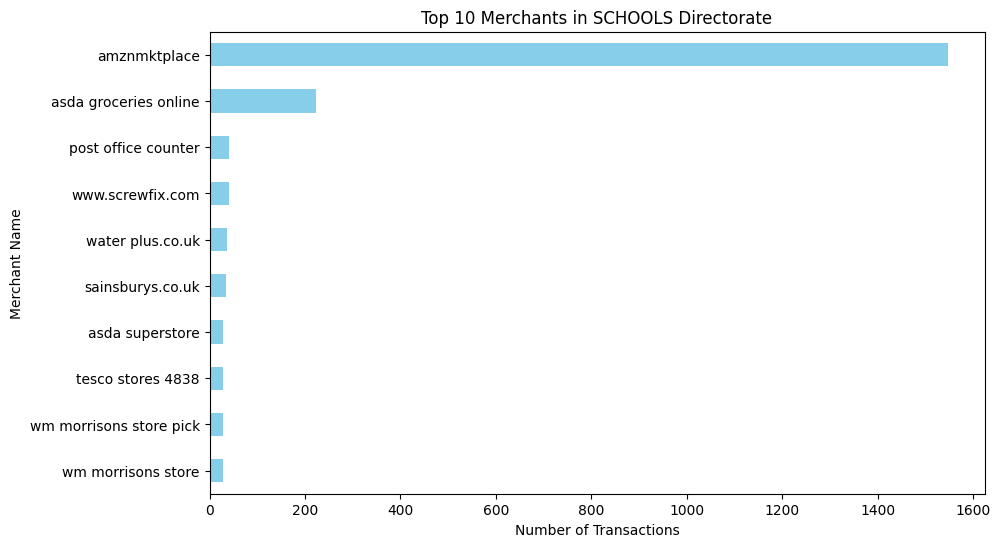

In [34]:
top_directorate = data_no_outliers['DIRECTORATE'].value_counts().idxmax()

# Filtering data for the top Directorate category
top_directorate_data = data_no_outliers[data_no_outliers['DIRECTORATE'] == top_directorate]

# Finding the top 10 merchants in this Directorate category
top_merchants_in_top_directorate = top_directorate_data['MERCHANT NAME'].value_counts().head(10)

# Plotting the top 10 merchants in the top Directorate category
plt.figure(figsize=(10, 6))
ax = top_merchants_in_top_directorate.plot(kind='barh', color='skyblue')
plt.title(f'Top 10 Merchants in {top_directorate} Directorate')
plt.xlabel('Number of Transactions')
plt.ylabel('Merchant Name')
ax.invert_yaxis()
plt.show()


### Grouping and Analysis: 
If applicable, I'll explore how to group these categories for better insights.

Integrating **DIRECTORATE** and **Directorate** Columns:
These columns appear to represent the same type of information but may have been duplicated due to data entry inconsistencies.




### Proposing Feature Handling: 
Based on the analysis, I'll suggest ways to handle various features for further modeling or analysis.

- **Numerical Features**: 
The strong correlations suggest that some features might be redundant. For instance, **ORIGINAL GROSS AMT** and **BILLING GROSS AMT** might be conveying similar information. Depending on the analysis or modeling objectives, one of these could potentially be dropped to reduce multicollinearity.

- **Categorical Features**:
For **TRANS TAX DESC** and similar columns with a wide variety of categories, consider grouping less frequent categories into an 'Other' category to simplify the analysis.
For **ORIGINAL CUR**, since there's a dominant currency, it might be more insightful to focus analyses on transactions in this currency or convert all amounts to a standard currency for uniformity.

In [ ]:
# Save Raw data aggregate 
rawdata.to_csv('data/interim/raw_aggregate.csv', index=False, encoding='utf-8')
rawdata.sample(1000).to_csv('data/interim/sample_to_test.csv', index=False, encoding='utf-8')